## Preparation

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [ ]:
# device check(CFDLab)
device=torch.device('cuda:1') #先調1再調0
print(torch.cuda.is_available())
x=torch.randn(100).to(device) # Gives warning

In [ ]:
device=torch.device('cuda:0') # Fix warning
x=torch.randn(100).to(device) # No warning

In [2]:
# device check(my pc)
device=torch.device('cpu')
print(torch.cuda.is_available())
x=torch.randn(100).to(device) # No warning

False


/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Parameters

In [3]:
batch=200 #batchsize
opt=1 # optimizer
tol=1e-8 # tolerance
n=[6400, 1000, 1000, 1000, 1000, 1000, 6400] #model layout
PATH= "DEL_SUP_FCN_TEST" # model name, saved as..

## Data

In [4]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
data_out=np.loadtxt('./data/preserved/output_P_1s.dat')
x_in=torch.Tensor(data_in)
y_in=torch.Tensor(data_out)

x_in=x_in[1:]-x_in[:-1]
y_in=y_in[1:]-y_in[:-1]

x_in=x_in.to(device)
y_in=y_in.to(device)

In [5]:
x=x_in
y=y_in
print(x.size())
print(y.size())

torch.Size([999, 6400])
torch.Size([999, 6400])


In [6]:
loader=DataLoader(TensorDataset(x, y), batch_size=batch)

## Model

In [7]:
# Step 2. Create model 建立model習慣建立class
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, A, B, C, D, E, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear_1=torch.nn.Linear(D_in, A)
        self.linear_2=torch.nn.Linear(A, B)
        self.linear_4=torch.nn.Linear(B, C)
        self.linear_5=torch.nn.Linear(C, D)
        self.linear_6=torch.nn.Linear(D, E)
        self.linear_3=torch.nn.Linear(E, D_out)
    
    # Step 3. Forward pass-1/2    # Step 4. Backward pass-1/2
    def forward(self, x):
        a=self.linear_1(x)
        a_relu=torch.nn.functional.relu(a) #為何activation and hidden layer 的實現方式不同
        b=self.linear_2(a_relu) 
        b_relu=torch.nn.functional.relu(b)
        c=self.linear_4(b_relu) 
        c_relu=torch.nn.functional.relu(c)
        d=self.linear_5(c_relu) 
        d_relu=torch.nn.functional.relu(d)
        e=self.linear_6(d_relu) 
        e_relu=torch.nn.functional.relu(e)
        y_pred=self.linear_3(e_relu) 
        return y_pred
    
model= TwoLayerNet(D_in=6400, A=n[1], B=n[2], C=n[3], D=n[4], E=n[5], D_out=6400)
model=model.to(device) #這行是什麼意思? A:将模型加载到相应的设备

## Training

In [8]:
if opt==0:
    optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
elif opt==1:
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

In [9]:
loss_epoch=[]
loss_values = []
loss=1
epochs=0

print("Epochs    Loss")

while(loss>tol):
    epochs=epochs+1
    scheduler.step()
    
    for x_batch, y_batch in loader:
        # Forward pass
        y_pred=model(x_batch)        
        loss=torch.nn.functional.mse_loss(y_pred, y_batch)
        
        # Backward pass
        loss.requires_grad_(True)
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
        #print("1 batch")
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%1==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        
    loss=loss.item()

print(epochs, "    ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

Epochs    Loss


/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epochs:  1 ; Loss:  4.374239142634906e-05
Epochs:  2 ; Loss:  1.527829772385303e-05
Epochs:  3 ; Loss:  5.883193352929084e-06
Epochs:  4 ; Loss:  2.4580090212111827e-06
Epochs:  5 ; Loss:  2.3846016574680107e-06
Epochs:  6 ; Loss:  9.487623628956499e-07
Epochs:  7 ; Loss:  7.084522053446562e-07
Epochs:  8 ; Loss:  4.962501520822116e-07
Epochs:  9 ; Loss:  2.468330819738185e-07
Epochs:  10 ; Loss:  1.9648580007469718e-07
Epochs:  11 ; Loss:  1.8553950553723553e-07
Epochs:  12 ; Loss:  1.2797202941783326e-07
Epochs:  13 ; Loss:  1.1578944025814053e-07
Epochs:  14 ; Loss:  8.68380993779283e-08
Epochs:  15 ; Loss:  4.91645891997905e-07
Epochs:  16 ; Loss:  1.4889093336023507e-07
Epochs:  17 ; Loss:  2.0499973629739543e-07
Epochs:  18 ; Loss:  1.6463408769595844e-07
Epochs:  19 ; Loss:  9.701570036213525e-08
Epochs:  20 ; Loss:  9.003652934325146e-08
Epochs:  21 ; Loss:  8.808698481743704e-08
Epochs:  22 ; Loss:  2.917145138781052e-07
Epochs:  23 ; Loss:  1.1137073840927769e-07
Epochs:  24 

AttributeError: 'float' object has no attribute 'item'

## Result

In [10]:
# Append name with time
from datetime import datetime
ct=datetime.now()
ctime=str(ct.year)+str(ct.month)+str(ct.day)+"_"+str(ct.hour)+str(ct.minute)+str(ct.second)
PATH=PATH+"_"+ctime #

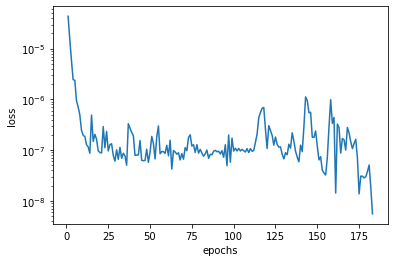

In [11]:
#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.semilogy()
plt.savefig("./result/"+PATH+'.png')

## Export

In [12]:
device=torch.device('cpu')
model=model.to(device)
traced_net=torch.jit.trace(model, (torch.randn(1,6400)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, "./result/"+PATH+".pth") #

In [13]:
# Save information
with open("./result/"+PATH+'.txt', 'w') as f:
        f.write('# Model info\n')
        f.write('Model: '+ PATH+'\n')
        f.write('ID: '+ ctime +'\n')
        f.write('Data format: '+ 'Delta' +'\n')
        f.write('Learning method: Supervised'+'\n')
        f.write('Model: FCN'+'\n')
        f.write('residual: '+str(tol)+'\n')
        f.write('batch_size: '+str(batch)+'\n')
        f.write('epochs: '+str(epochs)+'\n')